In [7]:
import sympy as sym
import sympy.physics.mechanics as me

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '..\..'))
import sympyTransforms as symt
import custom_plot_objects as cpo
import FwtModels.dof2 as dof2

F = sym.Matrix(me.dynamicsymbols(f'f:{2}'))
(F*2).subs(F[0],0)

Matrix([
[      0],
[2*f1(t)]])

In [2]:
# create the variables
p = dof2.FwtParameters()
p.m.value = 3
p.l.value = 1
p.s.value = 2
p.c.value = 0.15
p.k.value = 100
p.g.value = 9.81

p.m_w = p.AddParam(3,'m_w')
p.I_xx = p.AddParam(1/12*p.m.value*p.l.value**2,'I_xx')

# get generalised coords (theta and d)
qs = 2
q = sym.Matrix(me.dynamicsymbols(f'q:{qs}'))

# potential Energy
half = sym.Rational(1,2)
U = p.m*p.g*(-p.l*sym.cos(q[0])) + half*p.k*(q[1])**2

# Create Point masses

# Transform for the mass
wing_frame = symt.HomogenousTransform().Translate(0,0,q[1])
fwt_frame = wing_frame.R_x(-sym.pi*sym.Rational(1,2)+q[0]).Translate(0,p.l,0)
rot = sym.Matrix([-sym.pi*sym.Rational(1,2)+q[0],0,0])


mw = dof2.RigidElement.PointMass(wing_frame,sym.Matrix([0,0,0]),p.m_w)


M_fwt = dof2.MassMatrix(p.m,I_xx = p.I_xx)

m = dof2.RigidElement(fwt_frame,rot,M_fwt)


sm = dof2.SymbolicModel(q,U,[mw,m],p)

In [4]:
me.mechanics_printing()
sm.EoM

⎡                                    ⎛       2  ⎞       ⎤
⎢   g⋅l⋅m⋅sin(q₀) + l⋅m⋅sin(q₀)⋅q₁̈ + ⎝Iₓₓ + l ⋅m⎠⋅q₀̈    ⎥
⎢                                                       ⎥
⎢                                      2                ⎥
⎣k⋅q₁ + l⋅m⋅sin(q₀)⋅q₀̈ + l⋅m⋅cos(q₀)⋅q₀̇  + m⋅q₁̈ + m_w⋅q₁̈⎦

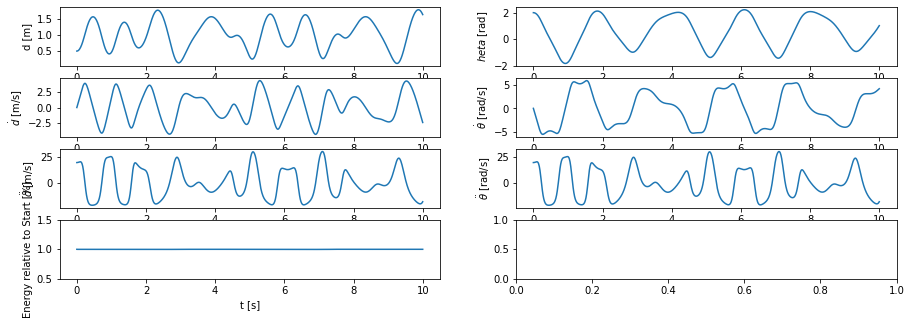

In [5]:
tmax, dt = 10, 0.01
# Initial conditions: theta, dtheta/dt, L, dL/dt

params = p.GetNumericTuple()


# y0 = [0.3,0,1,0]

test_case = 5

if test_case == 0:     # shows energy behaves itself when you dont pass through the singularity
    y0 = [1.3,0,-0.5,0]
    yData = solve_ivp(lambda t,y:sm.deriv(t,y,p),(0,tmax),y0,max_step=dt)
elif test_case == 1:   # shows it getting stuck on  singularity
    y0 = [0.3,0,0.6,0]
    yData = solve_ivp(lambda t,y:sm.deriv(t,y,p),(0,tmax),y0,max_step=dt)
elif test_case == 2:   # attempt to fix value through sigularity
    y0 = [0.3,0,0.6,0]
    yData = solve_ivp(lambda t,y:deriv_sing(t,y,p,sigma=0.01),(0,tmax),y0,max_step=dt)
elif test_case == 3:   # attempt to fix value through sigularity (tight sigma to show almost enrgy convergence)
    y0 = [0.3,0,0.6,0]
    yData = solve_ivp(lambda t,y:deriv_sing(t,y,p,sigma=0.0000001),(0,tmax),y0,max_step=dt)
elif test_case == 4:   # attempt to fix value through sigularity (open sigma to show sensible ish results)
    y0 = [0.3,0,0.6,0]
    yData = solve_ivp(lambda t,y:deriv_sing(t,y,p,sigma=0.1),(0,tmax),y0,max_step=dt)    
elif test_case == 5:     # shows energy behaves itself when you dont pass through the singularity
    y0 = [2,0,-0.5,0]
    yData = solve_ivp(lambda t,y:sm.deriv(t,y,p),(0,tmax),y0,max_step=dt)

# interpolate data onto a uniform time grid
t = np.arange(0, tmax+dt, 0.01)
yi = np.zeros((len(t),len(y0)+2)).T
for i in range(0,len(y0)):
    yi[i] = np.interp(t,yData.t,yData.y[i])
for i in range(0,2):
    yd = sm.deriv(0,yi[:4,:],p)
    yi[i+4,:] = yd[1]
    yi[i+4,:] = yd[3]
    
    
fig, axes = plt.subplots(4,2,figsize=(15,5))

# d plot
axes[0][0].plot(t,yi[2]+p.l.value)
axes[0][0].set_ylabel('d [m]')
axes[0][0].set_xlabel('t [s]')

# theta plot
axes[0][1].plot(t,yi[0])
axes[0][1].set_ylabel('$\theta$ [rad]')
axes[0][1].set_xlabel('t [s]')


# ddot plot
axes[1][0].plot(t,yi[3])
axes[1][0].set_ylabel('$\dot{d}$ [m/s]')
axes[1][0].set_xlabel('t [s]')

# thetadot plot
axes[1][1].plot(t,yi[1])
axes[1][1].set_ylabel(r'$\dot{\theta}$ [rad/s]')
axes[1][1].set_xlabel('t [s]')

# ddot plot
axes[2][0].plot(t,yi[4])
axes[2][0].set_ylabel('$\ddot{d}$ [m/s]')
axes[2][0].set_xlabel('t [s]')

# thetadot plot
axes[2][1].plot(t,yi[5])
axes[2][1].set_ylabel(r'$\ddot{\theta}$ [rad/s]')
axes[2][1].set_xlabel('t [s]')

# energy
axes[3][0].plot(t,sm.Energy(yi,p)/sm.Energy(yi[:,0],p))
axes[3][0].set_ylabel(r'Energy relative to Start [%]')
axes[3][0].set_xlabel('t [s]')
axes[3][0].set_ylim(0.5,1.5)



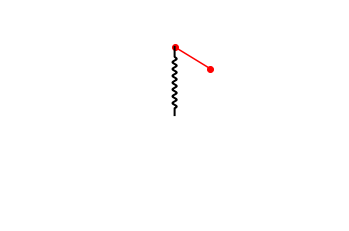

In [8]:
import matplotlib.animation as animation
from IPython.display import HTML

plt.rcParams['animation.ffmpeg_path'] = r'C:\Users\qe19391\OneDrive - University of Bristol\Documents\Programs\ffmpeg-20200211-f15007a\bin\ffmpeg.exe'

fig = plt.figure()
ax = plt.axes(xlim=(-3,3),ylim=(-6,6))
ax.axis('equal')
ax.set()
fwt, = ax.plot([],[],'ro-')
spring = cpo.Spring.FromLengthAndAngle(np.pi/2,p.l.value,ax = ax)

# initialization function 
def init(): 
    # creating an empty plot/frame 
    spring.ReplotSpring((0,0),np.pi,1+y0[2])
    fwt.set_data([0,p.l.value],[1,1])
    return spring.springObj,fwt
                    
def animate(i):
    theta = yi[0,i]
    d = yi[2,i]
    spring.ReplotSpring((0,0),np.pi,d+1)
    fwt.set_data([0,p.l.value*np.sin(theta)],[d+1,-p.l.value*np.cos(theta)+d+1])
    return spring.springObj,

plt.axis('off')    
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(t), interval=25, blit=True)
#anim.save(f'basic_animation_{test_case+1}.mp4', fps=30)
HTML(anim.to_html5_video())
